In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 19.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp "/content/drive/MyDrive/FDL21_RaVAEn_datasets/floods.zip" floods.zip
!unzip floods.zip
!rm floods.zip

Archive:  floods.zip
   creating: floods/
   creating: floods/EMSR333_02PORTOPALO/
   creating: floods/EMSR333_02PORTOPALO/changes_vector/
  inflating: floods/EMSR333_02PORTOPALO/changes_vector/2018-11-04.geojson  
   creating: floods/EMSR333_02PORTOPALO/S2/
  inflating: floods/EMSR333_02PORTOPALO/S2/2018-10-25.tif  
  inflating: floods/EMSR333_02PORTOPALO/S2/2018-10-20.tif  
  inflating: floods/EMSR333_02PORTOPALO/S2/2018-10-23.tif  
  inflating: floods/EMSR333_02PORTOPALO/S2/2018-10-30.tif  
  inflating: floods/EMSR333_02PORTOPALO/S2/2018-11-04.tif  
   creating: floods/EMSR333_02PORTOPALO/cloudprob_edited_vector/
  inflating: floods/EMSR333_02PORTOPALO/cloudprob_edited_vector/2018-11-04.geojson  
   creating: floods/EMSR333_02PORTOPALO/changes/
  inflating: floods/EMSR333_02PORTOPALO/changes/2018-11-04.tif  
   creating: floods/EMSR333_02PORTOPALO/floodmap_edited/
  inflating: floods/EMSR333_02PORTOPALO/floodmap_edited/2018-11-04.geojson  
   creating: floods/EMSR271_02FARKADONA/
  

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import os
import rasterio

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class FloodDataset(nn.Module):
    def __init__(self, patch_size=64):
        super(FloodDataset, self).__init__()
        self.patch_size = patch_size
        self.patches = []
        self.precompute_patches()

    def precompute_patches(self):
        root = os.listdir("floods")
        for path in root:
            img_paths = [os.path.join("floods", path, "S2", x) for x in os.listdir(os.path.join("floods", path, "S2")) if x.endswith(".tif")]
            for img_path in img_paths:
                with rasterio.open(img_path) as src:
                    img = src.read()  # Read all bands
                height, width = img.shape[1], img.shape[2]
                for row in range(0, height, self.patch_size):
                    for col in range(0, width, self.patch_size):
                        if row + self.patch_size <= height and col + self.patch_size <= width:
                            patch = img[:, row:row + self.patch_size, col:col + self.patch_size]
                            quantiles = np.quantile(patch, [0.01, 0.99], axis=(1, 2), keepdims=True)
                            patch = (patch - quantiles[0]) / (quantiles[1] - quantiles[0]+1e-5)
                            patch = np.clip(patch, 0,1)
                            patch = torch.tensor(patch, dtype=torch.float32)
                            if not torch.isnan(patch).any():
                                self.patches.append(patch)

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        return self.patches[idx]


In [3]:
ds = FloodDataset(patch_size=256)

split = 0.8
train_size = int(split * len(ds))
val_size = len(ds) - train_size
train_ds, val_ds = torch.utils.data.random_split(ds, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)



torch.Size([32, 15, 256, 256])


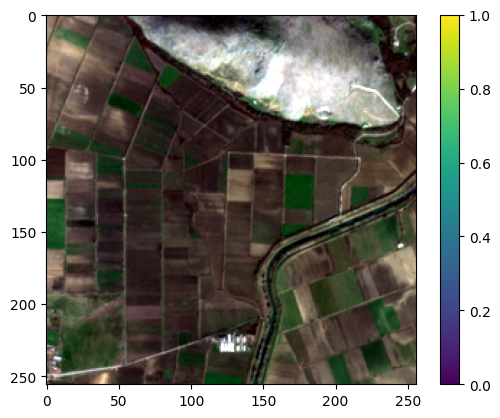

In [4]:
#Test train_loader
bands = [3,2,1]
data = next(iter(train_loader))
print(data.shape)
plt.imshow(data[0,bands,:,:].permute(1, 2, 0).numpy())
plt.colorbar()
plt.show()

In [5]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(15, 32, kernel_size=3, stride=2, padding=1),  # 4 input channels (
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 32 input channels
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 64 input channels
            nn.ReLU())
        self.fc_mu = nn.Linear(128 * 8 * 8 *16, 128)
        self.fc_logvar = nn.Linear(128 * 8 * 8 * 16, 128)
        self.fc_decode = nn.Linear(128, 128 * 8 * 8*16)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # 128 input channels
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 64 input channels
            nn.ReLU(),
            nn.ConvTranspose2d(32, 15, kernel_size=8, stride=2, padding=1),  # 32 input channels
            nn.Sigmoid())
        # 4 output channels (same as input)




    def encode(self, x):
        # Define the encoder part of the VAE
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.fc_decode(z)
        z = z.view(z.size(0), 128, 8*4, 8*4)
        x = self.decoder(z)
        return x

    def forward(self, x):
        # Forward pass through the VAE
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar



In [6]:
def loss_function(recon_x, x, mu, logvar, gamma):
    # Define the loss function for the VAE
    # Gamma is the variance of the prior
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = 0.5 * torch.sum(mu.pow(2)/gamma + logvar.exp()/gamma - logvar.size(1) - logvar + gamma.log())
    return MSE + KLD

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, train_loader, val_loader, gamma, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_idx, data in tqdm(enumerate(train_loader)):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar, gamma)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f"====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}")
        for batch_idx ,data in enumerate(val_loader):
            model.eval()
            data = data.to(device)
            val_loss = 0
            with torch.no_grad():
                recon_batch, mu, logvar = model(data)
                loss = loss_function(recon_batch, data, mu, logvar, gamma)
                val_loss += loss.item() / len(data)
        print(f"====> Validation loss: {val_loss / len(val_loader.dataset):.4f}")


In [7]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
gamma = torch.tensor([1]).to(device)
optimizer.add_param_group({'params': gamma})
train(model, train_loader, val_loader, gamma, optimizer, epochs=100)

16it [00:04,  3.40it/s]

====> Epoch: 0 Average loss: 51992.0010


====> Validation loss: 351.9083


16it [00:03,  4.54it/s]


====> Epoch: 1 Average loss: 41861.7249
====> Validation loss: 338.2534


16it [00:02,  5.61it/s]


====> Epoch: 2 Average loss: 39852.1885
====> Validation loss: 324.4336


16it [00:02,  5.65it/s]


====> Epoch: 3 Average loss: 37698.0059
====> Validation loss: 297.5393


16it [00:03,  4.13it/s]

====> Epoch: 4 Average loss: 35304.5596


====> Validation loss: 280.2170


16it [00:02,  5.57it/s]


====> Epoch: 5 Average loss: 32323.3169
====> Validation loss: 257.7795


16it [00:02,  5.62it/s]


====> Epoch: 6 Average loss: 29486.8690
====> Validation loss: 240.8153


16it [00:03,  5.11it/s]

====> Epoch: 7 Average loss: 27441.4330


====> Validation loss: 216.9277


16it [00:03,  5.07it/s]


====> Epoch: 8 Average loss: 25347.4429
====> Validation loss: 208.2604


16it [00:02,  5.51it/s]


====> Epoch: 9 Average loss: 23152.0383
====> Validation loss: 195.6628


16it [00:02,  5.53it/s]


====> Epoch: 10 Average loss: 21288.1340
====> Validation loss: 183.1579


16it [00:03,  4.25it/s]


====> Epoch: 11 Average loss: 19363.6355
====> Validation loss: 175.9684


16it [00:02,  5.59it/s]


====> Epoch: 12 Average loss: 17873.9902
====> Validation loss: 168.3464


16it [00:02,  5.52it/s]


====> Epoch: 13 Average loss: 16602.3584
====> Validation loss: 164.7731


16it [00:03,  4.45it/s]

====> Epoch: 14 Average loss: 15146.0625


====> Validation loss: 152.8362


16it [00:03,  5.23it/s]


====> Epoch: 15 Average loss: 13656.8708
====> Validation loss: 143.8704


16it [00:03,  4.32it/s]


====> Epoch: 16 Average loss: 12415.6808
====> Validation loss: 134.9869


16it [00:03,  4.51it/s]

====> Epoch: 17 Average loss: 11444.1704


====> Validation loss: 132.0840


16it [00:02,  5.51it/s]


====> Epoch: 18 Average loss: 10609.1796
====> Validation loss: 124.0112


16it [00:02,  5.53it/s]


====> Epoch: 19 Average loss: 9516.2919
====> Validation loss: 119.9575


16it [00:03,  5.25it/s]


====> Epoch: 20 Average loss: 8628.0672
====> Validation loss: 114.3466


16it [00:03,  4.64it/s]


====> Epoch: 21 Average loss: 7885.1592
====> Validation loss: 109.0821


16it [00:02,  5.36it/s]


====> Epoch: 22 Average loss: 7218.8751
====> Validation loss: 107.9128


16it [00:02,  5.53it/s]


====> Epoch: 23 Average loss: 6693.2261
====> Validation loss: 104.5815


16it [00:03,  4.07it/s]


====> Epoch: 24 Average loss: 6158.1178
====> Validation loss: 102.7152


16it [00:04,  3.58it/s]


====> Epoch: 25 Average loss: 5679.6590
====> Validation loss: 100.7563


16it [00:03,  4.13it/s]

====> Epoch: 26 Average loss: 5526.5268


====> Validation loss: 103.9441


16it [00:03,  5.22it/s]


====> Epoch: 27 Average loss: 5850.5042
====> Validation loss: 105.2340


16it [00:02,  5.45it/s]


====> Epoch: 28 Average loss: 5305.6028
====> Validation loss: 98.2885


16it [00:02,  5.34it/s]


====> Epoch: 29 Average loss: 4599.1715
====> Validation loss: 95.3973


16it [00:03,  4.72it/s]


====> Epoch: 30 Average loss: 4162.2388
====> Validation loss: 92.0929


16it [00:02,  5.36it/s]


====> Epoch: 31 Average loss: 3734.9691
====> Validation loss: 92.3793


16it [00:02,  5.40it/s]


====> Epoch: 32 Average loss: 3348.8355
====> Validation loss: 90.9350


16it [00:03,  4.10it/s]


====> Epoch: 33 Average loss: 3296.0127
====> Validation loss: 92.1781


16it [00:02,  5.38it/s]


====> Epoch: 34 Average loss: 3036.2844
====> Validation loss: 92.5594


16it [00:03,  5.32it/s]


====> Epoch: 35 Average loss: 2818.6229
====> Validation loss: 89.3501


16it [00:03,  4.23it/s]

====> Epoch: 36 Average loss: 2708.4088


====> Validation loss: 87.7895


16it [00:02,  5.42it/s]


====> Epoch: 37 Average loss: 2508.3846
====> Validation loss: 88.0035


16it [00:02,  5.41it/s]

====> Epoch: 38 Average loss: 2363.7501


====> Validation loss: 87.7463


16it [00:03,  5.07it/s]

====> Epoch: 39 Average loss: 2208.6729


====> Validation loss: 88.4332


16it [00:03,  4.98it/s]


====> Epoch: 40 Average loss: 2135.0052
====> Validation loss: 86.5782


16it [00:03,  5.21it/s]


====> Epoch: 41 Average loss: 2023.0424
====> Validation loss: 85.3659


16it [00:03,  4.98it/s]

====> Epoch: 42 Average loss: 1856.7173


====> Validation loss: 86.5146


16it [00:03,  4.50it/s]


====> Epoch: 43 Average loss: 1663.4693
====> Validation loss: 85.9906


16it [00:02,  5.39it/s]


====> Epoch: 44 Average loss: 1520.4406
====> Validation loss: 86.5833


16it [00:02,  5.41it/s]


====> Epoch: 45 Average loss: 1392.1637
====> Validation loss: 84.7192


16it [00:03,  4.16it/s]


====> Epoch: 46 Average loss: 1196.8494
====> Validation loss: 85.4906


16it [00:02,  5.44it/s]


====> Epoch: 47 Average loss: 1072.3269
====> Validation loss: 85.3917


16it [00:02,  5.35it/s]


====> Epoch: 48 Average loss: 1009.6383
====> Validation loss: 84.8537


16it [00:03,  4.44it/s]

====> Epoch: 49 Average loss: 971.8629


====> Validation loss: 84.3380


16it [00:03,  4.82it/s]


====> Epoch: 50 Average loss: 1007.7736
====> Validation loss: 87.6595


16it [00:02,  5.36it/s]

====> Epoch: 51 Average loss: 968.2337


====> Validation loss: 84.7530


16it [00:05,  2.82it/s]


====> Epoch: 52 Average loss: 1031.2484
====> Validation loss: 84.7405


16it [00:02,  5.36it/s]


====> Epoch: 53 Average loss: 934.4056
====> Validation loss: 87.9691


16it [00:02,  5.41it/s]


====> Epoch: 54 Average loss: 761.5515
====> Validation loss: 85.7526


16it [00:03,  4.04it/s]

====> Epoch: 55 Average loss: 707.0854


====> Validation loss: 84.7191


16it [00:02,  5.41it/s]


====> Epoch: 56 Average loss: 478.5088
====> Validation loss: 84.8570


16it [00:02,  5.39it/s]


====> Epoch: 57 Average loss: 268.4925
====> Validation loss: 84.6525


16it [00:03,  4.64it/s]

====> Epoch: 58 Average loss: 131.4034


====> Validation loss: 85.6179


16it [00:03,  5.26it/s]


====> Epoch: 59 Average loss: 84.7473
====> Validation loss: 85.3200


16it [00:02,  5.45it/s]


====> Epoch: 60 Average loss: -1.0497
====> Validation loss: 82.6378


16it [00:03,  5.20it/s]

====> Epoch: 61 Average loss: -154.6435


====> Validation loss: 84.7164


16it [00:03,  4.62it/s]


====> Epoch: 62 Average loss: -295.5835
====> Validation loss: 85.8758


16it [00:02,  5.40it/s]


====> Epoch: 63 Average loss: -296.0293
====> Validation loss: 84.7125


16it [00:03,  5.24it/s]


====> Epoch: 64 Average loss: -435.2363
====> Validation loss: 86.1141


16it [00:03,  4.28it/s]


====> Epoch: 65 Average loss: -524.5266
====> Validation loss: 83.9269


16it [00:02,  5.50it/s]


====> Epoch: 66 Average loss: -562.2384
====> Validation loss: 82.6544


16it [00:02,  5.41it/s]


====> Epoch: 67 Average loss: -552.9582
====> Validation loss: 85.5376


16it [00:03,  4.44it/s]


====> Epoch: 68 Average loss: -548.9725
====> Validation loss: 87.2149


16it [00:02,  5.43it/s]

====> Epoch: 69 Average loss: -482.6493


====> Validation loss: 84.6913


16it [00:02,  5.45it/s]


====> Epoch: 70 Average loss: -566.3889
====> Validation loss: 86.2467


16it [00:03,  5.00it/s]

====> Epoch: 71 Average loss: -695.0898


====> Validation loss: 86.1591


16it [00:03,  4.77it/s]


====> Epoch: 72 Average loss: -915.0333
====> Validation loss: 83.9335


16it [00:03,  5.08it/s]

====> Epoch: 73 Average loss: -1014.4322


====> Validation loss: 84.5625


16it [00:02,  5.43it/s]

====> Epoch: 74 Average loss: -1084.1042


====> Validation loss: 85.7511


16it [00:03,  4.45it/s]


====> Epoch: 75 Average loss: -1177.3078
====> Validation loss: 84.1090


16it [00:03,  5.11it/s]


====> Epoch: 76 Average loss: -1262.9481
====> Validation loss: 85.6140


16it [00:02,  5.46it/s]


====> Epoch: 77 Average loss: -1283.2236
====> Validation loss: 88.5559


16it [00:04,  3.89it/s]


====> Epoch: 78 Average loss: -1221.9768
====> Validation loss: 84.7687


16it [00:02,  5.33it/s]


====> Epoch: 79 Average loss: -1329.7743
====> Validation loss: 84.7738


16it [00:02,  5.43it/s]

====> Epoch: 80 Average loss: -1411.6394


====> Validation loss: 85.7919


16it [00:03,  4.21it/s]


====> Epoch: 81 Average loss: -1509.2458
====> Validation loss: 85.1060


16it [00:03,  4.32it/s]


====> Epoch: 82 Average loss: -1587.8188
====> Validation loss: 84.3735


16it [00:02,  5.37it/s]


====> Epoch: 83 Average loss: -1609.1106
====> Validation loss: 86.1465


16it [00:03,  5.13it/s]


====> Epoch: 84 Average loss: -1617.3592
====> Validation loss: 86.0652


16it [00:03,  4.72it/s]


====> Epoch: 85 Average loss: -1686.0301
====> Validation loss: 85.9700


16it [00:03,  4.69it/s]


====> Epoch: 86 Average loss: -1662.8891
====> Validation loss: 88.4070


16it [00:02,  5.40it/s]

====> Epoch: 87 Average loss: -1577.4706


====> Validation loss: 85.5865


16it [00:03,  4.50it/s]


====> Epoch: 88 Average loss: -1530.1682
====> Validation loss: 85.0453


16it [00:02,  5.38it/s]


====> Epoch: 89 Average loss: -1391.7972
====> Validation loss: 88.2172


16it [00:02,  5.37it/s]


====> Epoch: 90 Average loss: -1467.9367
====> Validation loss: 86.7348


16it [00:03,  4.07it/s]


====> Epoch: 91 Average loss: -1630.1551
====> Validation loss: 87.4629


16it [00:02,  5.36it/s]


====> Epoch: 92 Average loss: -1764.2739
====> Validation loss: 89.4766


16it [00:03,  5.31it/s]


====> Epoch: 93 Average loss: -1849.8512
====> Validation loss: 86.4097


16it [00:03,  4.59it/s]


====> Epoch: 94 Average loss: -1910.2022
====> Validation loss: 85.2168


16it [00:02,  5.41it/s]


====> Epoch: 95 Average loss: -1938.8915
====> Validation loss: 85.5846


16it [00:02,  5.42it/s]


====> Epoch: 96 Average loss: -1904.1055
====> Validation loss: 85.4927


16it [00:03,  5.08it/s]


====> Epoch: 97 Average loss: -2045.6032
====> Validation loss: 85.2357


16it [00:03,  4.71it/s]


====> Epoch: 98 Average loss: -2135.4740
====> Validation loss: 89.0581


16it [00:02,  5.34it/s]


====> Epoch: 99 Average loss: -2173.2161
====> Validation loss: 86.2121


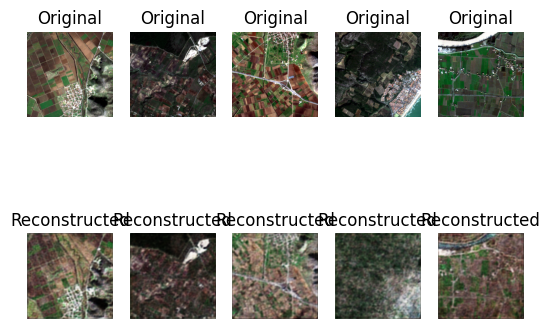

In [11]:
data = next(iter(val_loader))

data = data.to(device)
recon_batch, mu, logvar = model(data)
recon_batch = recon_batch.cpu().detach().numpy()
data = data.cpu().detach().numpy()

for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(data[i, bands, :, :].transpose(1, 2, 0))
    plt.title("Original")
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(recon_batch[i, bands, :, :].transpose(1, 2, 0))
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()



In [19]:
mu, logvar = model.encode(torch.Tensor(data[0:1]).to(device))
import numpy as np
mu, logvar = mu.cpu().detach().numpy(), logvar.cpu().detach().numpy()
# Generate batch without ablation
z_no_ablation = np.random.normal(loc=mu, scale=np.exp(logvar), size=(500,128))

recon_no_ablation = model.decode(torch.Tensor(z_no_ablation).to(device))
recon_no_ablation = recon_no_ablation.cpu().detach().numpy()

# Generate batch with ablation
z_ablation = torch.Tensor(z_no_ablation).clone()
z_ablation[:, 64:127] = 0
z_ablation = z_ablation.to(device)
recon_ablation = model.decode(z_ablation)
recon_ablation = recon_ablation.cpu().detach().numpy()


err_map = np.var(data[0:1] - recon_no_ablation, axis=0)
err_map = np.mean(err_map, axis=0)

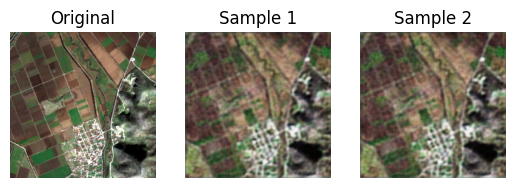

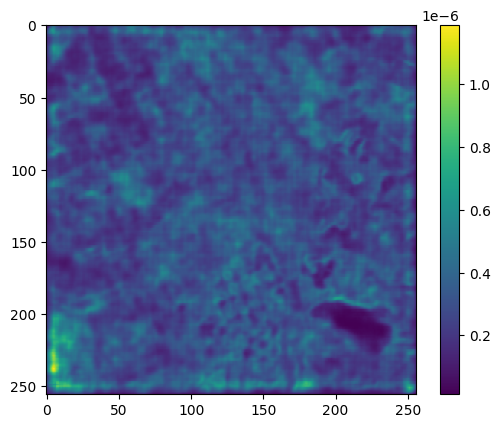

In [23]:
plt.subplot(1,3,1)
plt.imshow(data[0,bands,:,:].transpose(1, 2, 0))
plt.title("Original")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(recon_no_ablation[0,bands,:,:].transpose(1, 2, 0))
plt.title("Sample 1")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(recon_no_ablation[1,bands,:,:].transpose(1, 2, 0))
plt.title("Sample 2")
plt.axis('off')

plt.show()

plt.imshow(err_map)
plt.colorbar()
plt.show()